In [ ]:
#hide
#default_exp visualization.experiment_visualization
from nbdev.showdoc import show_doc
import warnings
warnings.filterwarnings('ignore')

# Visualization utils

## Plot history

In [ ]:
#export
import numpy as np
#import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
from IPython.display import display
import visdom
from hpsearch.config.hpconfig import get_path_results, get_path_experiments
import hpsearch.utils.experiment_utils as ut
from hpsearch.visualization import plot_utils 
import warnings
warnings.filterwarnings('ignore')
    
              
def plot_multiple_histories (experiments, run_number=0, root_path=None, root_folder=None, metrics='all', 
                             metrics_second=[], parameters = None, compare = True, 
                             ylegend=0.5, name_file='model_history.pk', 
                             op='max', include_parameters_in_legend=False,
                             backend='visdom', **kwargs):
    
    if root_path is None:
        root_path = get_path_experiments(folder=root_folder)
    
    df = pd.read_csv('%s/experiments_data.csv' %root_path,index_col=0)
    df = ut.replace_with_default_values (df)
    df2 = ut.get_experiment_parameters (df.loc[experiments], only_not_null=True)
    parameters2, df2 = ut.get_parameters_unique(df2)

    if compare or parameters is not None:        
        if parameters is None:
            parameters = parameters2 
        df = df.loc[experiments,parameters]
    
    if type(metrics)==str and (metrics == 'all'):
        path_results = get_path_results (experiments[0], run_number=run_number, root_path=root_path)
        history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
        metrics = history.keys()
    if type(metrics) == str:
        metrics = [metrics]
    if type(metrics_second) == str:
        metrics_second = [metrics_second]
    
    df_show = df.copy()
    
    for (imetric,metric) in enumerate(metrics):
        title = metric
        traces = []
        for experiment_id in experiments:
            path_results = get_path_results (experiment_id, run_number=run_number, root_path=root_path)
            if os.path.exists('%s/%s' %(path_results, name_file)):
                history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
                #values = [float(x) for x in history[metric]]
                if compare and include_parameters_in_legend:
                    label = '{}-{}'.format(experiment_id, list(dict(df.loc[experiment_id]).values()))
                else:
                    label = '{}'.format(experiment_id)
                traces = plot_utils.add_trace (history[metric], style='A.-', label=label, backend=backend, traces=traces)
                
                if True:
                    if op == 'min':
                        imin = int(np.array(history[metric]).argmin())
                    else:
                        imin = int(np.array(history[metric]).argmax())
                    vmin = float(history[metric][imin])
                    traces = plot_utils.add_trace ([imin], [vmin], style='.', label='', backend=backend, 
                                                   marker={'color': 'red', 'symbol': 104, 'size': 10},
                                                   traces=traces)
                    
                    title += ' [%d]: %.2f' %(experiment_id, vmin)
                    df_show.loc[experiment_id, metric] = vmin
                    df2.loc[experiment_id, metric] = vmin
                if (imetric == 0):
                    for metric_second in metrics_second:
                        #values = [float(x) for x in history[metric_second]]
                        if compare and include_parameters_in_legend:
                            label = '{}: {}-{}'.format(metric_second, experiment_id, list(dict(df.loc[experiment_id]).values()))
                        else:
                            label = '{}: {}'.format(metric_second, experiment_id)
                        traces = plot_utils.add_trace (history[metric_second], style='A.-', label=label, backend=backend, traces=traces)
                        
                        if op == 'min':
                            imin = int(np.array(history[metric_second]).argmin())
                        else:
                            imin = int(np.array(history[metric_second]).argmax())
                        vmin = float(history[metric_second][imin])
                        traces = plot_utils.add_trace ([imin], [vmin], style='.', label='', backend=backend, 
                                                   marker={'color': 'red', 'symbol': 104, 'size': 10},
                                                   traces=traces)
                        title += ' [%d]: %.2f' %(experiment_id, vmin)
                        df_show.loc[experiment_id, metric_second] = vmin
                        df2.loc[experiment_id, metric_second] = vmin

        plot_utils.plot(title=title, xlabel='epoch', ylabel=metric, traces=traces, backend=backend)
        if backend=='visdom':
            vis = visdom.Visdom()
            vis.text (df_show.to_html(justify='left', col_space=100), win= f'{metric}_parameters')
        display(df2)


using import method 1


Using TensorFlow backend.


using import method 1


In [ ]:
#collapse_output
from hpsearch.examples.dummy_experiment_manager import remove_previous_experiments, run_multiple_experiments

remove_previous_experiments()
run_multiple_experiments(nruns=5, noise=0.1)
run_multiple_experiments(nruns=5, noise=0.1, rate = 0.1)

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 212
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0010046958923339844
0 - validation_accuracy: 0.305631422238463
0 - test_accuracy: 0.5033292509850051
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0008816719055175781
1 - validation_accuracy: 0.2646120610831435
1 - test_accuracy: 0.39271056491116846
finished experiment 0
processing hyper-parame

using import method 1
using import method 1
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering


running experiment 0
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009448528289794922
3 - validation_accuracy: 0.12324518908084134
3 - test_accuracy: 0.3695921082340699
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009005069732666016
4 - validation_accuracy: 0.41789660359512437
4 - test_accuracy: 0.3848767390278466
finished experiment 0
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hp

fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0010809898376464844
2 - validation_accuracy: 0.4521507130717074
2 - test_accuracy: 0.4353095366482435
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0008935928344726562
3 - validation_accuracy: 0.6295219227132647
3 - test_accuracy: 0.4207548634596724
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experime

fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009276866912841797
1 - validation_accuracy: 0.7175494387561314
1 - test_accuracy: 0.8628375966286369
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009508132934570312
2 - validation_accuracy: 0.7191744723080403
2 - test_accuracy: 0.8055234094085176
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experime

fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
registering


running experiment 3
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001893758773803711
0 - validation_accuracy: 0.6054410736077539
0 - test_accuracy: 0.37903018862015925
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0018169879913330078
1 - validation_accuracy: 0.575299459922657
1 - test_accuracy: 0.45007877676527464
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/h

fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 


parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0020203590393066406
4 - validation_accuracy: 0.5716679654661798
4 - test_accuracy: 0.5125785194815164
finished experiment 3
processing hyper-parameter 4 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0018548965454101562
0 - validation_accuracy: 0.8121013332663769
0 - test_accuracy: 0.4509427381012443
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_exp

fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epo

finished experiment 4
processing hyper-parameter 4 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001961231231689453
3 - validation_accuracy: 0.5588159912422294
3 - test_accuracy: 0.5628520382984434
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0019445419311523438
4 - validation_accuracy: 0.6591867057979535
4 - test_accuracy: 0.6547163048390563
finished experiment 4
processing hyper-parameter 5 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
run

registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: acc


parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.00197601318359375
1 - validation_accuracy: 1.0
1 - test_accuracy: 0.9763297832852534
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.002277851104736328
2 - validation_accuracy: 1.0
2 - test_accuracy: 0.9522333319837616
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 

fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.930000000

running experiment 6
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0034155845642089844
0 - validation_accuracy: 0.2927829924944443
0 - test_accuracy: 0.22438088111441556
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0035212039947509766
1 - validation_accuracy: 0.34913514267799656
1 - test_accuracy: 0.4405446089782935
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena

registering
fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.49000000000000

running experiment 6
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0033202171325683594
3 - validation_accuracy: 0.5163581812849081
3 - test_accuracy: 0.40204752824966417
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0031888484954833984
4 - validation_accuracy: 0.46724938643031977
4 - test_accuracy: 0.2839313680388093
finished experiment 6
processing hyper-parameter 7 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena

fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.5200000000000002
epoch 26: accuracy: 0.4900000000000002
epoch 27:

time spent on this experiment: 0.004697322845458984
1 - validation_accuracy: 0.5635754688642789
1 - test_accuracy: 0.5321846062356068
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003275156021118164
2 - validation_accuracy: 0.5662112305583923
2 - test_accuracy: 0.5982782617229508
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003377676010131836
3 - validation_accuracy: 0.5938375720740909
3 - test_accuracy: 0.629

fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.7500000000000003
epoch 25: accuracy: 0.720000000

time spent on this experiment: 0.003997325897216797
4 - validation_accuracy: 0.4360904178918894
4 - test_accuracy: 0.4870391121940211
finished experiment 7
processing hyper-parameter 8 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0033817291259765625
0 - validation_accuracy: 1.0
0 - test_accuracy: 0.7734307464799904
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003239154815673828
1 - validation_accuracy: 1.0
1 - test_accuracy: 0.8413861631116624
finished experi

registering
fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.

finished experiment 8
processing hyper-parameter 8 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003570079803466797
3 - validation_accuracy: 0.9065438301025369
3 - test_accuracy: 0.6185103662678293
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0032148361206054688
4 - validation_accuracy: 0.8324330871750214
4 - test_accuracy: 0.7120719535193413
finished experiment 8


registering
fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 212
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0008871555328369141
0 - validation_accuracy: 0.6760419532668581
0 - test_accuracy: 0.757044274072341
finished experiment 9
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009765625
1 - validation_accuracy: 0.5721439265061625
1 - test_accuracy: 0.6683890283470186
finished experiment 9
processing hyper-parameter 0 out of


registering
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6


finished experiment 9
processing hyper-parameter 0 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0008840560913085938
3 - validation_accuracy: 0.8131553736582049
3 - test_accuracy: 0.5378593700275757
finished experiment 9
processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009069442749023438
4 - validation_accuracy: 0.30403429706490637
4 - test_accuracy: 0.6870389855164168
finished experiment 9
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
runni

registering
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999


finished experiment 10
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009083747863769531
1 - validation_accuracy: 0.6863050220555496
1 - test_accuracy: 0.9696470611441881
finished experiment 10
processing hyper-parameter 1 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009329319000244141
2 - validation_accuracy: 0.5384505459676983
2 - test_accuracy: 1.0
finished experiment 10
processing hyper-parameter 1 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experime

registering
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999


finished experiment 10
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0008907318115234375
4 - validation_accuracy: 0.6853141744384887
4 - test_accuracy: 0.9769214366331762
finished experiment 10
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009076595306396484
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 11
run numbe

registering
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
registering


time spent on this experiment: 0.0009899139404296875
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0012326240539550781
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009386539459228516
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 4 

fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
registering
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
registering


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0009992122650146484
4 - validation_accuracy: 0.9972315711361318
4 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 3 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0019669532775878906
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0018870830535888672
1 - validation_

fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accur

running experiment 12
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0021479129791259766
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001878976821899414
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.60000

running experiment 13
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0021567344665527344
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001909017562866211
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004

running experiment 13
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0019562244415283203
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0020837783813476562
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 5 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, lin

fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004

running experiment 14
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001926422119140625
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 5 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.001836538314819336
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line 

fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
registering
fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000

running experiment 14
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.002003908157348633
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 6 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0033409595489501953
0 - validation_accuracy: 0.9720230723321036
0 - test_accuracy: 1.0
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_m

fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
registering
fitting model with 30 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 1

running experiment 15
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0037491321563720703
2 - validation_accuracy: 0.9467578579653277
2 - test_accuracy: 1.0
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003353595733642578
3 - validation_accuracy: 0.9149546848160562
3 - test_accuracy: 1.0
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dum

fitting model with 30 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
epoch 15: accuracy: 1.7000000000000004
epoch 16: accuracy: 1.8000000000000005
epoch 17: accuracy: 1.9000000000000006
epoch 18: accuracy: 2.0000000000000004
epoch 19: accuracy: 2.1000000000000005
epoch 20: accuracy: 2.0000000000000004
epoch 21: accuracy: 1.9000000000000004
epoch 22: accuracy: 1.8000000000000003
epoch 23: accuracy: 1.7000000000000002
epoch 24: accuracy: 1.6
epoch 25: accuracy: 1.5
epoch 26: accuracy: 1.4
epoch 27: accuracy: 1.2999999999999998
epoch 28: accuracy: 1.1999999999999997

running experiment 16
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003432035446166992
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0037038326263427734
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 30 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
epoch 15: accuracy: 1.9000000000000006
epoch 16: accuracy: 2.0000000000000004
epoch 17: accuracy: 2.1000000000000005
epoch 18: accuracy: 2.2000000000000006
epoch 19: accuracy: 2.3000000000000007
epoch 20: accuracy: 2.2000000000000006
epoch 21: accuracy: 2.1000000000000005
epoch 22: accuracy: 2.0000000000000004
epoch 23: accuracy: 1.9000000000000004
epoch 24: accuracy: 1.8000000000000003
epoch 25: accuracy: 1.7000000000000002
epoch 26: accuracy: 1.6
epoch 27: accuracy: 1.5
epoch 28:

running experiment 16
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003525257110595703
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003264188766479492
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 8 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line 

fitting model with 30 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
epoch 15: accuracy: 1.9000000000000006
epoch 16: accuracy: 2.0000000000000004
epoch 17: accuracy: 2.1000000000000005
epoch 18: accuracy: 2.2000000000000006
epoch 19: accuracy: 2.3000000000000007
epoch 20: accuracy: 2.2000000000000006
epoch 21: accuracy: 2.1000000000000005
epoch 22: accuracy: 2.0000000000000004
epoch 23: accuracy: 1.9000000000000004
epoch 24: accuracy: 1.8000000000000003
epoch 25: accuracy: 1.7000000000000002
epoch 26: accuracy: 1.6
epoch 27: accuracy: 1.5
epoch 28:

running experiment 17
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0033566951751708984
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 17
processing hyper-parameter 8 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.0034935474395751953
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 17
processing hyper-parameter 8 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, lin

fitting model with 30 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
epoch 15: accuracy: 2.2000000000000006
epoch 16: accuracy: 2.3000000000000007
epoch 17: accuracy: 2.400000000000001
epoch 18: accuracy: 2.500000000000001
epoch 19: accuracy: 2.600000000000001
epoch 20: accuracy: 2.500000000000001
epoch 21: accuracy: 2.400000000000001
epoch 22: accuracy: 2.3000000000000007
epoch 23: accuracy: 2.2000000000000006
epoch 24: accuracy: 2.1000000000000005
epoch 25: accuracy: 2.0000000000000004
epoch 26: accurac

running experiment 17
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 212
time spent on this experiment: 0.003820180892944336
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 17


fitting model with 30 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
epoch 15: accuracy: 2.2000000000000006
epoch 16: accuracy: 2.3000000000000007
epoch 17: accuracy: 2.400000000000001
epoch 18: accuracy: 2.500000000000001
epoch 19: accuracy: 2.600000000000001
epoch 20: accuracy: 2.500000000000001
epoch 21: accuracy: 2.400000000000001
epoch 22: accuracy: 2.3000000000000007
epoch 23: accuracy: 2.2000000000000006
epoch 24: accuracy: 2.1000000000000005
epoch 25: accuracy: 2.0000000000000004
epoch 26: accurac

### Usage examples

Plot all the metrics that have been stored in model_history

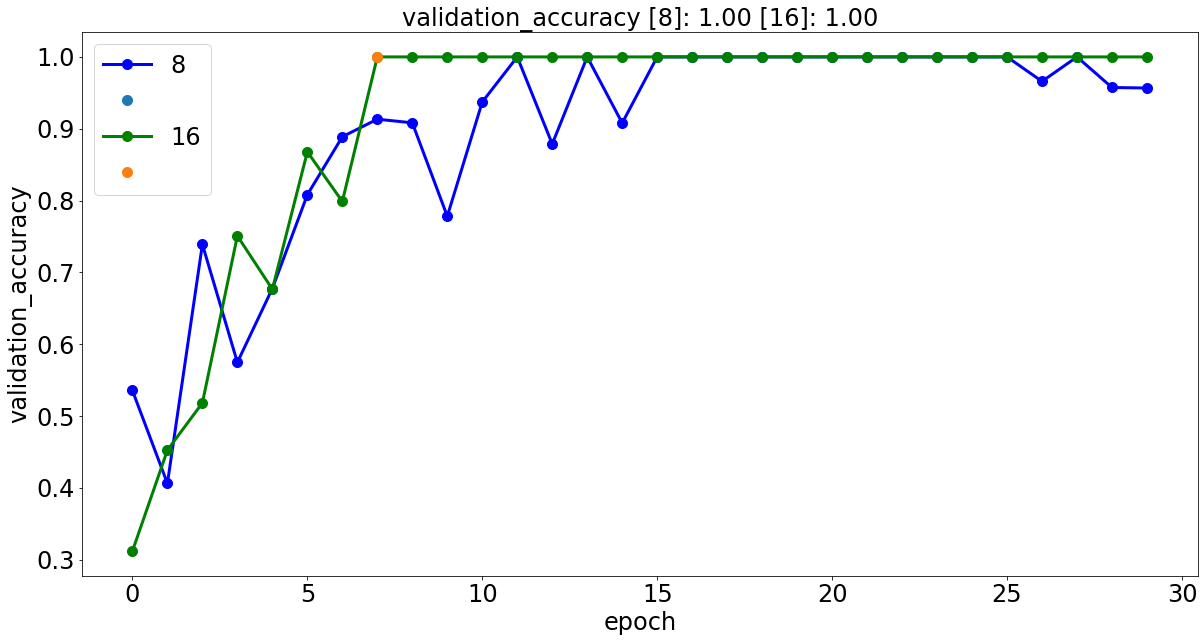

,offset,rate,validation_accuracy
8,0.6,0.03,1.0
16,0.3,0.10,1.0


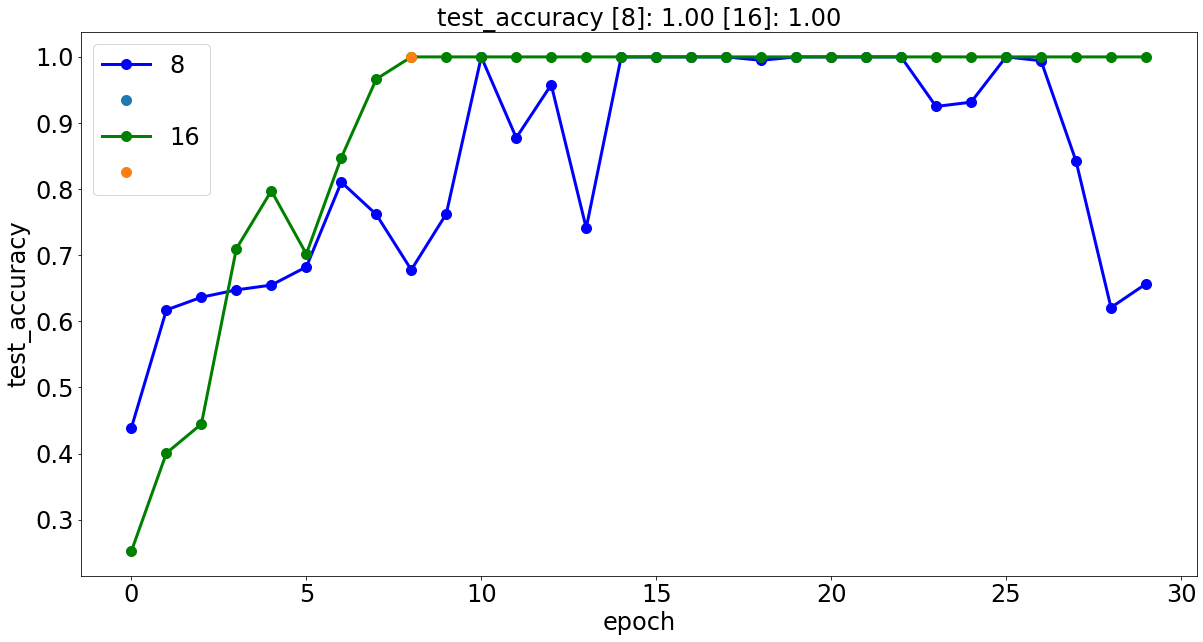

,offset,rate,validation_accuracy,test_accuracy
8,0.6,0.03,1.0,1.0
16,0.3,0.10,1.0,1.0


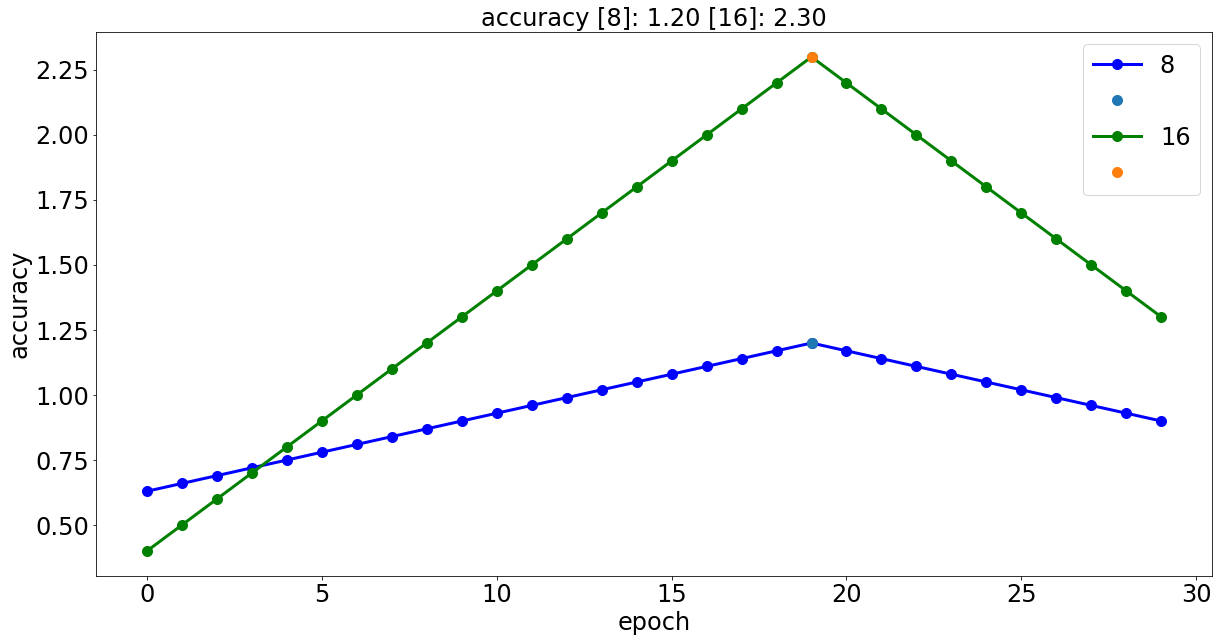

,offset,rate,validation_accuracy,test_accuracy,accuracy
8,0.6,0.03,1.0,1.0,1.2
16,0.3,0.10,1.0,1.0,2.3


In [ ]:
plot_multiple_histories ([8,16], run_number=0, op='max', backend='matplotlib')

### Plot only one metric, and three experiments

We plot the test_accuracy metric

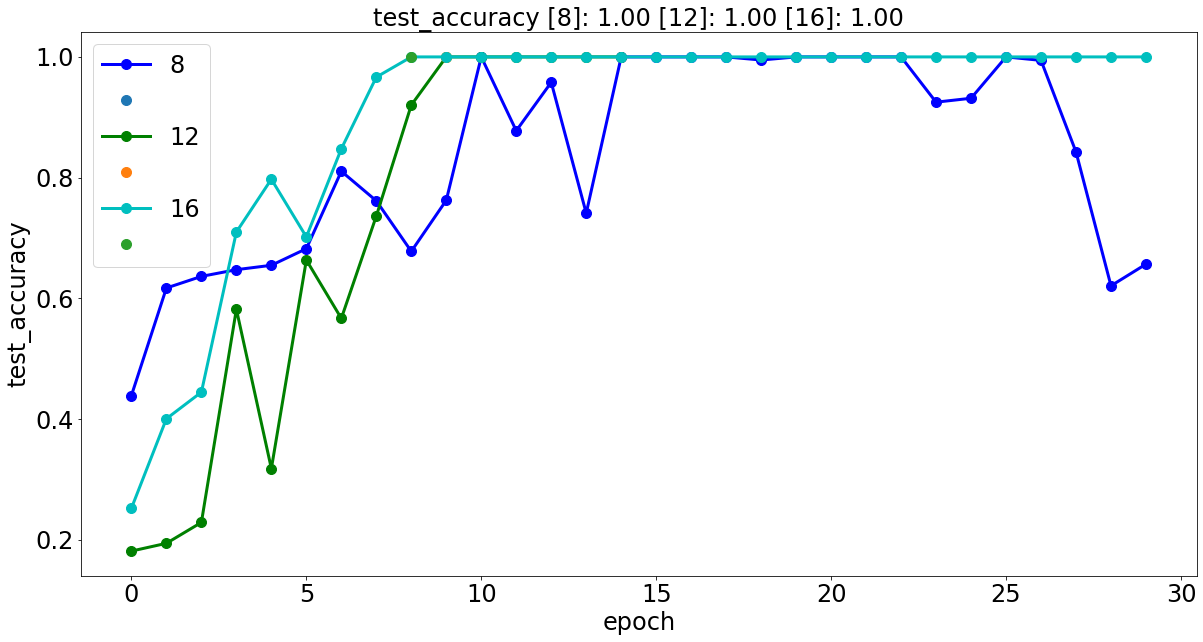

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


In [ ]:
plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='matplotlib')

### Use plotly as backend

In [ ]:
plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='plotly')

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


## Metric correlation

Displays the relationship between scores obtained across experiments with two different evaluation metrics indicated as argument. Calculates Pearson R-squared coefficient.

In [ ]:
#export

def plot_metric_relationship (metric_1, metric_2, folder_experiments=None, run_numbers=None, 
                              experiments=None, experiment_subset=None,
                              backend='visdom', **kwargs):
    df = ut.get_experiment_data (folder_experiments=folder_experiments, experiments=experiments)
    df_metric_1 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
    df_metric_2 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
    
    traces=plot_utils.add_trace(df_metric_1.values, df_metric_2.values, traces=[], style='A.', label='all experiments', backend=backend);
    
    if experiment_subset is not None:
        df_metric_1_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
        df_metric_2_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
        traces=plot_utils.add_trace(df_metric_1_subset.values, df_metric_2_subset.values, traces=traces, style='A.', label=f'selected subset', backend=backend);
    
    plot_utils.plot(np.linspace(df_metric_1.values.min(), df_metric_1.values.max(), 100), 
                np.linspace(df_metric_2.values.min(), df_metric_2.values.max(), 100), 
                traces=traces, style='A-', label='linear', title=f'{metric_1} vs {metric_2}', xlabel=metric_1, ylabel=metric_2, backend=backend);

## usage examples

Illustrate usage based on dummy experiment manager

#### plot relationship between validation and accuracy metrics

In [ ]:
plot_metric_relationship ('validation_accuracy', 'test_accuracy', backend='plotly')

#### 3. Highlight selected experiments

In [ ]:
plot_metric_relationship ('validation_accuracy', 'test_accuracy', experiment_subset=[5,2], backend='plotly')

## visualize_experiments

Main experiment visualization entry function

In [ ]:
#export
## Generic Visualization
def visualize_experiments (visualization='history', **kwargs):
    if type(visualization) is str:
        visualization_list = [visualization]
    else:
        visualization_list = visualization
    for visualization in visualization_list:
        parameters = kwargs.copy()
        if visualization == 'history':
            assert 'experiments' in kwargs.keys(), 'experiments parameter expected when visualization is "history"'
            experiments = parameters.pop('experiments')
            plot_multiple_histories (experiments, **parameters)
        elif visualization == 'metric_correlation':
            assert 'metric_1' in kwargs.keys(), 'metric_1 parameter expected when visualization is "metric_correlation"'
            assert 'metric_2' in kwargs.keys(), 'metric_2 parameter expected when visualization is "metric_correlation"'
            metric_1 = parameters.pop('metric_1')
            metric_2 = parameters.pop('metric_2')
            plot_metric_relationship (metric_1, metric_2, **parameters)
        else:
            from hpsearch.config.hpconfig import experiment_visualization

            experiment_visualization (visualization=visualization, **kwargs)

In [ ]:
visualize_experiments (visualization=['history', 'metric_correlation', 'custom'], experiments=[8,12, 16], 
                       run_number=0, op='max', metrics = 'test_accuracy', backend='plotly',
                       metric_1='test_accuracy', metric_2='validation_accuracy')

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


In [ ]:
#hide
from nbdev.export import *
notebook2script(recursive=True)

Converted hpconfig.ipynb.
Converted manager_factory.ipynb.
Converted complex_dummy_experiment_manager.ipynb.
Converted dummy_experiment_manager.ipynb.
Converted example_experiment.ipynb.
Converted example_experiment_manager.ipynb.
Converted experiment_manager.ipynb.
Converted index.ipynb.
Converted change_manager.ipynb.
Converted metric_visualization.ipynb.
Converted print_parameters.ipynb.
Converted print_table.ipynb.
Converted query.ipynb.
Converted remove_experiments.ipynb.
Converted experiment_utils.ipynb.
Converted organize_experiments.ipynb.
Converted resume_from_checkpoint.ipynb.
Converted experiment_visualization.ipynb.
Converted plot_utils.ipynb.
